<a href="https://colab.research.google.com/github/daphnecor/Neuro-analysis/blob/first-draft-content/NA1_PlaceCells.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Neuro-analysis Assignment 1: Place cells

```
Student: Daphne Cornelisse
```


In [ ]:
'''
Dependencies
'''
import numpy as np
import scipy
import scipy.stats
import scipy.io
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

from ipywidgets import interact
import ipywidgets as widgets

cmap = sns.color_palette("cubehelix", as_cmap=True)
sns.set_context('notebook')
plt.rcParams['figure.figsize'] = [10, 5]

## Part 1. Simulating place cells 

Place cells are cells in the hippocampus that activate when the animal (typically rat or mouse) passes through a specific place in an environment. Together place cells form a spatial map of the environment that is supposed to support episodic memory. A good review on place cells is the one by [Moser et al](https://www.annualreviews.org/doi/full/10.1146/annurev.neuro.31.061307.090723?url_ver=Z39.88-2003&rfr_id=ori%3Arid%3Acrossref.org&rfr_dat=cr_pub%3Dpubmed). Some more information on the hippocampus [here](http://www.scholarpedia.org/article/Hippocampus#Hippocampal_place_cells_and_episode_cells)

In a typical place cell experiment, multiple hippocampal neurons are recorded at the same time eg. with a multi-eletrode array. For each cell (as a result of the spike sorting process, that we will not cover here) we get the time series of the times of the spikes that each cell emitted. In addition we will get information about the position of the animal at any point in time. Typically, this is obtained by filming the animal movement with a video-camera, and use a video-tracking algorithm to find the animal position in each frame. Thus, we will get a time series with the times of each frame and the position of the animal (X and Y coordinates, or in the case of running on a linear track, only a 1-D coordinate. To find the animal position at the moment of the emission of each spike (which is the basic unit of information for our analysis) we will therefore have to "synchronize and realign" these different types of time series. 


To get started, we will create and analyze some simulated data, where we will have more control. We will first generate "ground truth" firing rate maps, and then simulate spike trains as inhomogeneous Poisson processes, with a rate determined by the current animal position. 
An inhomogeneous Poisson process is a random process where the instantaneous probability to have an event at time $t$ (more precisely, the probability of having an event between times $t$ and $t + dt$ is given by:

$$p(\text{event in}[t, t+dt]) = \lambda(t)dt$$

Here we define the parameters for the simulation. We will consider a 1-D environment, such as linear track

In [ ]:
track_length = 200. # The length of our linear track (eg in centimeter)
average_firing_rate = 5 # The peak firing rate, averaged across the population 
n_cells = 100 # How many cells we are recording
pf_centers = np.random.rand(n_cells) * track_length # The centers of the place fields for all cells drawn randomly with a uniform distribution on the track
pf_size = np.random.gamma(10, size=n_cells) # The size (width) of the place fields, drawn randomly from a gamma distribution 
pf_rate = np.random.exponential(scale=average_firing_rate, size=n_cells) # The peak firing rate for each cell, drawn from an exponential distribution

The probaility distribution for the place field size has shape

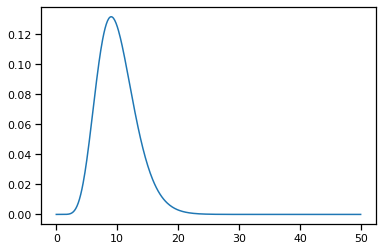

In [ ]:
x = np.arange(0., 50., 0.1) # We use a grid with step 0.1
g = scipy.stats.gamma.pdf(x, 10) 
plt.plot(x, g);

In [ ]:
bins = np.arange(0., 200.)
true_firing_rate_maps = np.zeros((n_cells, len(bins)))
for i in range(n_cells):
    true_firing_rate_maps[i,:] = pf_rate[i] * np.exp(-((bins-pf_centers[i])**2)/(2*pf_size[i]**2))

Here is what the true place field maps will look like

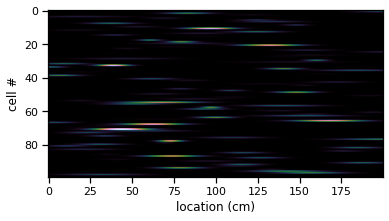

In [ ]:
plt.imshow(true_firing_rate_maps, cmap=cmap)
plt.xlabel('location (cm)')
plt.ylabel('cell #');

Now plotting them in the order of place field (common plot type in the field)

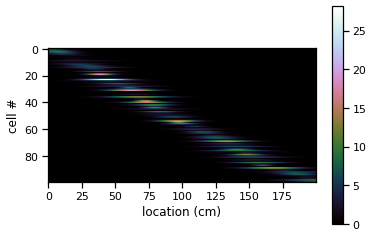

In [ ]:
ix = np.argsort(pf_centers)
plt.imshow(true_firing_rate_maps[ix,:], cmap=cmap)
plt.xlabel('location (cm)')
plt.ylabel('cell #')
plt.colorbar();

now let's simulate the "mouse" trajectory. The mouse will shuttle back and forth on the linear track and will stop at the two ends to eat. We will make a very rough simulation, in which the running speed will be constant for each run

In [ ]:
n_runs = 20 
av_running_speed = 10 # the average running speed (in cm/s)
fps = 30 # the number of "video frames" per second 
running_speed_a = np.random.chisquare(10, size=n_runs) # running speed in the two directions
running_speed_b = np.random.chisquare(10, size=n_runs) 

stopping_time_a = np.random.chisquare(15, size=n_runs) # the time the mouse will spend at the two ends of the track
stopping_time_b = np.random.chisquare(15, size=n_runs)

x = np.array([])
for i in range(n_runs):
    stop1 = np.ones((int(stopping_time_a[i]*fps),)) * 0.
    run_length = len(bins) * fps / running_speed_a[i]
    run1 = np.linspace(0., float(len(bins)-1), int(run_length))
    stop2 = np.ones((int(stopping_time_b[i]*fps),)) * (len(bins)-1.)
    run_length = len(bins) * fps / running_speed_b[i]
    run2 = np.linspace(len(bins)-1., 0., int(run_length))
    x = np.concatenate((x, stop1, run1, stop2, run2))
t = np.arange(len(x))/fps


`t` and `x` are, respectively, the times, and position readouts for all the video frames. This pair represent the first time series that we will encounter in a typical experiment

This is what the mouse trajectory looks like

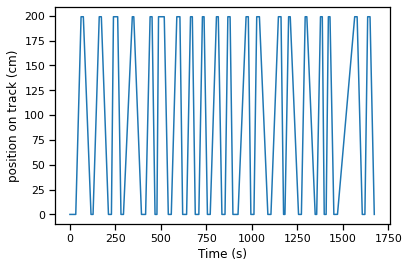

In [ ]:
plt.plot(t, x)
plt.xlabel('Time (s)')
plt.ylabel('position on track (cm)');

### Simulate spike trains

The cell below draws spikes according to an inhomogeneous Poisson process. This is the hear of the simulation. Look at the `for` loop, what is each line of code doing?

In [ ]:
sampling_rate = 10000.
t_sampling = np.arange(0, t[-1], 1. / sampling_rate)
x_sampling = np.floor(np.interp(t_sampling, t, x))
noise_firing_rate = 0.1 # The baseline noise firing rate
spikes = []

for i in range(n_cells):
    inst_rate = true_firing_rate_maps[i, x_sampling.astype(np.int32)] + noise_firing_rate
    spikes_loc = np.random.poisson(inst_rate/sampling_rate)
    sp = np.argwhere(spikes_loc)
    t_sp = t_sampling[sp]
    spikes.append(t_sp)

`spikes` and the pair `t, x` contain the information that we typically get from an experiment. Thus, our analyses will focus on those. 

In the lines below, we plot the positions at which the spikes are fired. 

Note two important things

- the use of `np.interp` (check the documentation!) to realign the spikes and the position time series. That instruction returns a series of the positions at which spikes were fired. This is a key operation that you will perform many times in the context of these analyses 

- the use of `interact` (from `ipywidgets`) to make an interactive plot so that we quickly explore the behavior of all cells



In [ ]:
def plot_unit(i):
    plt.plot(t, x)
    plt.plot(spikes[i], np.interp(spikes[i], t, x), 'r.')
    
interact(plot_unit, i = widgets.IntSlider(min=0, max=(n_cells-1), value=0));

interactive(children=(IntSlider(value=0, description='i', max=99), Output()), _dom_classes=('widget-interact',…

In [ ]:
# Get spike positions for each neuron
spike_positions = [np.interp(s, t, x) for s in spikes]

Now let's make experimental firing rate maps, by taking the histogram of the spikes at each position and normalizing it by the "occupancy" that is, the time at each point on the track.

In [ ]:
space_bins = np.arange(0, 200, 5)

# We compute histograms for each cell
spikes_hist= [np.histogram(s, space_bins)[0] for s in spike_positions]

# Put them together into a matrix of floating point numbers (for plotting)
spikes_hist = np.vstack(spikes_hist).astype(np.float64)

# we also need an "occupancy histogram" in order to normalize the firing rates maps 
occupancy = np.histogram(x, space_bins)[0] /  fps

firing_rate_maps = spikes_hist / occupancy 

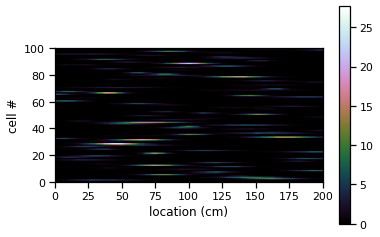

In [ ]:
plt.imshow(firing_rate_maps, cmap=cmap, extent = [0, 200, 0, n_cells])
plt.xlabel('location (cm)')
plt.ylabel('cell #')
plt.colorbar();

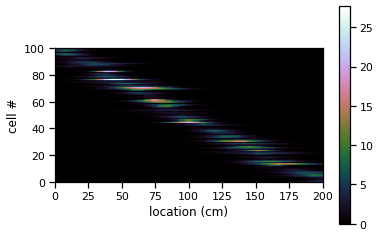

In [ ]:
peak_locations = firing_rate_maps.argmax(axis=1)
ix = np.argsort(peak_locations)
plt.imshow(firing_rate_maps[ix,:], cmap=cmap, extent = [0, 200, 0, n_cells])
plt.xlabel('location (cm)')
plt.ylabel('cell #')
plt.colorbar();

#### Question 1

---

> Explore what happens when you change the binning in the above definition of the firing rate maps (`space_bins`). Make it coarser or broader. 

---

Just like with a 1D histogram, increasing the bin size widens the bins. Here, we see that increasing the bin size enlarges the location interval for which the neurons fire. In other words, it decreases the resolution of the exact locations for which place cells fire. 

#### Question 2

---

> In the spike train simulations, we add some "baseline" noise, not place-related to the firing. Which variable determines the noise level? Try to experiment with that variable and see what happens to the firing rate maps. What is the best approach to firing rate maps when the noise is high.

---

The variable that sets the baseline noise is called `noise_firing_rate`. Increasing the noise level increases the overall firing rate. Thus, it is less clear from the firing rate maps where the exact center of the place field is (preferred location for a given neuron). One approach to deal with this could be to enlarge any differences in firing rates for the neurons. 


#### Question 4

---

> When analyzing place fields, two important quantities are the place field center and the place field width. The place field center may be defined in many ways, but one is to compute the "center of mass" of the spikes according to the equation 
$$ c_{pf} = \frac{1}{N_{spikes}} \sum_{i} L_i $$ 
where the sum on $i$ runs on all spikes emitted by a cell and $L_i$ is the location at which the i-th spike was emitted. Calculate this for each cell. Compare with the "true" place field centers from the simulations (which variables are we talking about?) 

---

Below I compute the Center of mass for each of the cells using the variable `spike_positions`. We overlay this with the firing rate maps and check how they compare. 



In [ ]:
cof_mass = [1/sp.shape[0] * np.sum(sp) for sp in spike_positions]

The center of mass values are plotted as white dots in on top of the firing rate maps. As can be seen in the plot below, the center of mass values match quite well with the true place field centers.

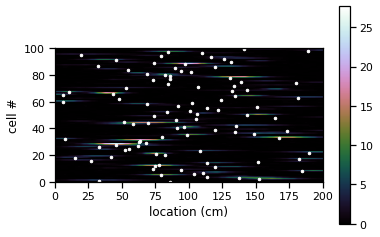

In [ ]:
plt.imshow(firing_rate_maps, cmap=cmap, extent = [0, 200, 0, n_cells])
plt.plot(cof_mass[::-1], range(len(cof_mass)), 'w.', ms=5)
plt.xlabel('location (cm)')
plt.ylabel('cell #')
plt.colorbar();

## Mutual information 

What makes a place cell? We are looking for cells with some amount of spatial selectivity. But how to we define/quantify that precisely?
One way is to use information theory. In particular mutual information is a way to quantify the degree of association between two random variables, such as the firing of an hippocampal cell and the position of a mouse. [Skaggs et al.](https://papers.nips.cc/paper/671-an-information-theoretic-approach-to-deciphering-the-hippocampal-code.pdf) defined a widely used formula to compute this "spatial information"  for the case of place cells. 

$$ I = \sum_x \lambda(x) \log_2 \frac{\lambda(x) + \epsilon}{\lambda} p_{occ}(x) $$ 

Where $\epsilon$ is a very small number (e.g. $10^{-15}$) This small number avoids infinities (and NaNs) when $\lambda(x) = 0$.


where $\lambda(x)$ is the firing rate map (as defined above, with some binning precision) $\lambda$ is the average firing rate of the neuron, and $p_{occ}(x)$ is the occupancy as defined above. Information from this formula is expressed in bits per second. An alternative definition is expressed in bits/spike:

$$ I_s = \frac{I}{\lambda}$$ 

(same formula as above divided by average firing rate). This second definition favors low-firing rate cells (typical for place cells)

#### Question 5

---

> Implement this formula, and calculate the mutual information for the cells in the simulation above

---

In [ ]:
'''
Parameterize
'''
p_occ = occupancy / np.max(occupancy) # Normalize the occupancies so that they become probabilities (likelihood)
lambdas_x = firing_rate_maps # Firing rates for each cell and location
eps = 1e-15 # Small number
I = []
I_s = []

for i in range(100):
  # Take firing rate for all locations of one cell
  lam_x = lambdas_x[i, :]

  # Take average
  lam = np.mean(lam_x)

  # Compute the mutual information for each cell (x=location)
  I.append(np.sum([lam_x[x] * p_occ[x] * np.log2((lam_x[x] + eps) / lam) for x in range(len(lam_x))]))
  I_s.append(np.sum([lam_x[x] * p_occ[x] * np.log2((lam_x[x] + eps) / lam) for x in range(len(lam_x))])/lam)

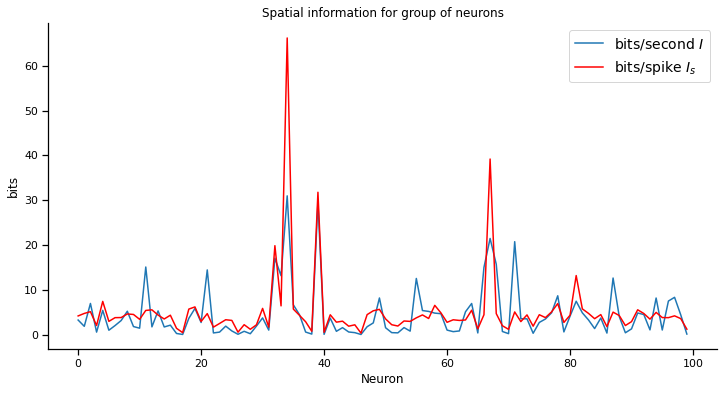

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 6))

ax.set_title(r'Spatial information for group of neurons')
ax.set_xlabel('Neuron')
ax.set_ylabel(r'bits')
ax.plot(I, label=r'bits/second $I$')
ax.plot(I_s, color='r', label=r'bits/spike $I_s$')
ax.legend(fontsize=14);
sns.despine()

## Working with real data


In [ ]:
# Load spiketies data
f_st = scipy.io.loadmat('/content/spiketimes.mat')

# Put the spike times in the same format as for the simulations
spike_times = f_st['spike_times']

# List of np arrays with the spike time series
spikes = [spike_times[0][i].ravel() for i in range(len(spike_times[0]))]

# Get position data 
f_pos = scipy.io.loadmat('/content/position.mat')

# Get same format as simulations
t = f_pos['t'].ravel()
x = f_pos['x'].ravel()

Let's take a look at the data, you will see that is a much more mixed bag than the simulation: there are cells that fire little, there are interneurons (cells that fire a lot, with little spatial selectivity). The same interactive plot as above will help a lot 

In [ ]:
interact(plot_unit, i = widgets.IntSlider(min=0, max=(len(spikes)-1), value=0));

interactive(children=(IntSlider(value=0, description='i', max=107), Output()), _dom_classes=('widget-interact'…

#### Question 7

---

> Reproduce the firing rate maps we produced for the simulation, in proper sorting order.

---

In [ ]:
# Get spike positions for each neuron
spike_positions = [np.interp(s, t, x) for s in spikes]

In [ ]:
space_bins = np.arange(0, 100, 2)

# We compute histograms for each cell
spikes_hist = [np.histogram(s, space_bins)[0] for s in spike_positions]

# Put them together into a matrix of floating point numbers (for plotting)
spikes_hist = np.vstack(spikes_hist).astype(np.float64)

# we also need an "occupancy histogram" in order to normalize the firing rates maps 
occupancy = np.histogram(x, space_bins)[0] /  fps

firing_rate_maps = spikes_hist / occupancy 

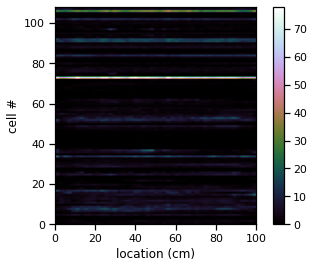

In [ ]:
plt.imshow(firing_rate_maps[::-1], cmap=cmap, extent = [0, 100, 0, 108])
plt.xlabel('location (cm)')
plt.ylabel('cell #')
plt.colorbar();

Unlike the simulated data, we don't see clear place fields. Furthermore, the firing rate of neuron 72 (white line in plot) is much higher than the firing rate of the other neurons and active for all locations. 

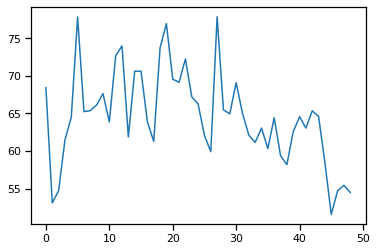

In [ ]:
plt.plot(firing_rate_maps[72, :]); # One neuron with consistent high fr rate for all locations

#### Question 8 

---

> Calculate the mutual information for each cell (both bits/sec and bits/spike)

---


In [ ]:
'''
Parameterize
'''
p_occ = occupancy / np.max(occupancy) # Normalize the occupancies so that they become probabilities (likelihood)
lambdas_x = firing_rate_maps # Firing rates for each cell and location
eps = 1e-15 # Small number
I = []
I_s = []

for i in range(len(firing_rate_maps)):
  # Take firing rate for all locations of one cell
  lam_x = lambdas_x[i, :]

  # Take average
  lam = np.mean(lam_x)

  # Compute the mutual information for each cell (x=location)
  I.append(np.sum([lam_x[x] * p_occ[x] * np.log2((lam_x[x] + eps) / lam) for x in range(len(lam_x))]))
  I_s.append(np.sum([lam_x[x] * p_occ[x] * np.log2((lam_x[x] + eps) / lam) for x in range(len(lam_x))])/lam)

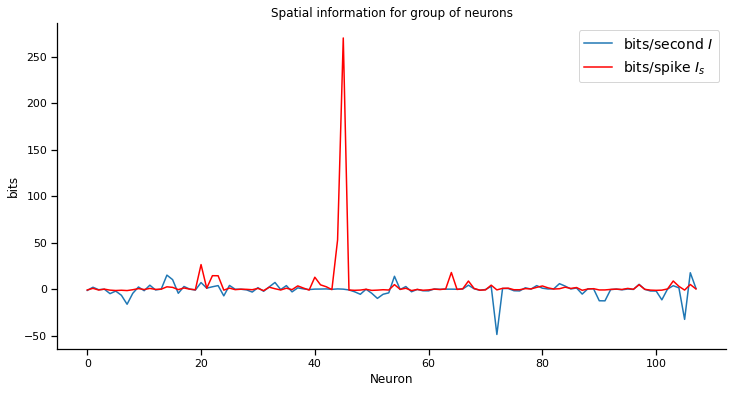

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 6))

ax.set_title(r'Spatial information for group of neurons')
ax.set_xlabel('Neuron')
ax.set_ylabel(r'bits')
ax.plot(I, label=r'bits/second $I$')
ax.plot(I_s, color='r', label=r'bits/spike $I_s$')
ax.legend(fontsize=14);
sns.despine()

## 2D Data

Last, we will work form data recorded while the mouse was exploring a 2D environment (square box), this is contained in the `2D` directory from the same zip file. 

Data loading goes pretty much as in the previous case, except that now there is also a `y` position variable.

In [ ]:
f = scipy.io.loadmat('/content/2D_spiketimes.mat')

spike_times = f['spike_times']

spikes = np.array([spike_times[0][i].ravel() for i in range(len(spike_times[0]))])

f = scipy.io.loadmat('/content/2D_position.mat')
t = f['t'].ravel()
x = f['x'].ravel()
y = f['y'].ravel()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  """


#### Question 11

---

> Compute the firing rate map for each cell, and use eg an interactive plot (if in a notebook) to display them all. You can use the function `np.histogram2d` 

---



We make a function that plots the activity per neuron in 2D space. Note that the activity patterns for some neurons are more place field-like compared to others. These may be the interneurons. 

In [ ]:
def plot_unit_2D(i):
    spike_positions_x = [np.interp(s, t, x) for s in spikes][i]
    spike_positions_y = [np.interp(s, t, y) for s in spikes][i]
    
    plt.plot(x, y)
    plt.plot(spike_positions_x, spike_positions_y, 'r.')

In [ ]:
interact(plot_unit_2D, i = widgets.IntSlider(min=0, max=100));

interactive(children=(IntSlider(value=0, description='i'), Output()), _dom_classes=('widget-interact',))

In [ ]:
'''
Dependencies for the animation
'''
from matplotlib import animation
from IPython.display import HTML

In [ ]:
spike_positions_x = [np.interp(s, t, x) for s in spikes]
spike_positions_y = [np.interp(s, t, y) for s in spikes]
space_bins = 25

# Make 2d histogram
spikes_hist = [np.histogram2d(i, j, space_bins)[0] for i,j in zip(spike_positions_x, spike_positions_y)]

In [ ]:
fig = plt.gcf()
im = plt.imshow(np.real(spikes_hist[0]), cmap='cubehelix')
fig.colorbar(im)
plt.close()
    
def animate(i):
    im.set_data(np.real(spikes_hist[i]))
    return im,
    
anim = animation.FuncAnimation(fig, animate, frames=range(0,len(spikes_hist)), interval=30, repeat=True)
display(HTML(anim.to_jshtml()))

Plotting the firing rate maps for all neurons shows that some are clearly active for a particular region/location in space. For most however, it is not entirely clear, suggesting that these are not place cells. In general, the activity patterns are quite noisy and therefore need more preprocessing. 